<a href="https://colab.research.google.com/github/mmesap/Difusion-de-ideologias-online/blob/main/Exploracion_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
#Se importa la Base de datos a un data frame
file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/soc-redditHyperlinks-title.tsv'
df = pd.read_csv(file_path, delimiter='\t')

In [ ]:
# Crear un grafo dirigido
G = nx.DiGraph()

# Iterar a través del DataFrame para añadir nodos y enlaces
for index, row in df.iterrows():
    source = row['SOURCE_SUBREDDIT']
    target = row['TARGET_SUBREDDIT']
    post_label = row['LINK_SENTIMENT']
    post_properties = list(map(float, row['PROPERTIES'].split(',')))

    # Añadir nodos
    if not G.has_node(source):
        G.add_node(source)
    if not G.has_node(target):
        G.add_node(target)

    # Añadir un enlace dirigido del subreddit fuente al subreddit objetivo
    G.add_edge(source, target, post_label=post_label, post_properties=post_properties)

In [ ]:
len(G)

54075

# Exploración de la red general

Distribución de Grado de entrada y salida

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo
in_degrees = dict(G.in_degree())  # Grado de entrada
out_degrees = dict(G.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

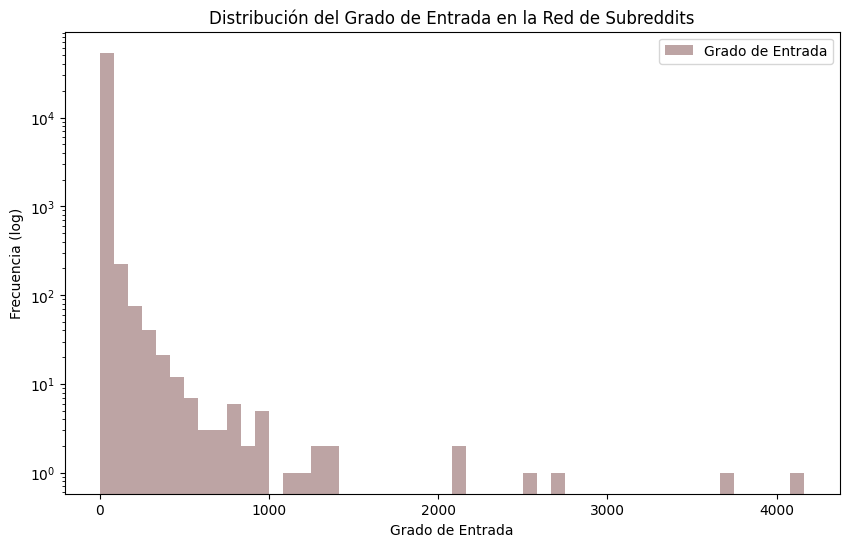

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Red de Subreddits')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

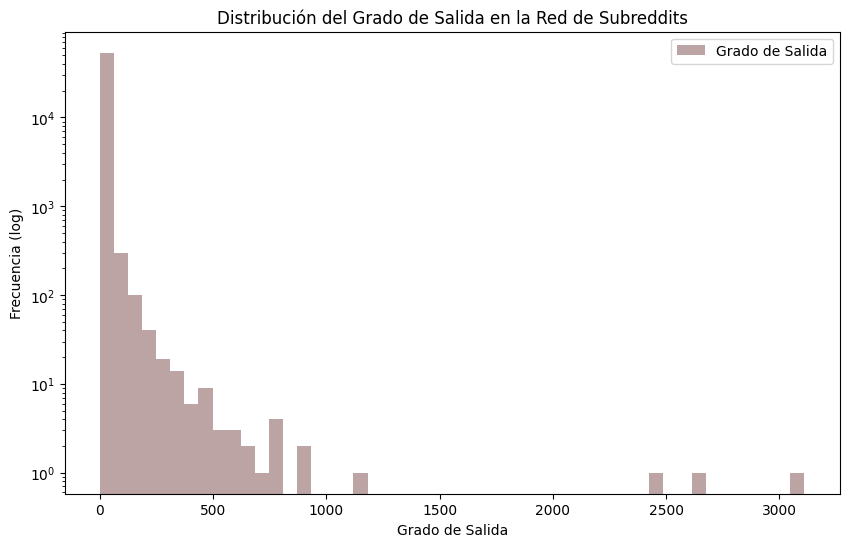

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Red de Subreddits')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

La distribución tiene una forma de cola larga (long-tail), lo cual es típico de muchas redes sociales y naturales. Esto significa que la mayoría de los subreddits tienen un grado de salida relativamente bajo (hacen referencia a unos pocos otros subreddits), mientras que hay unos pocos subreddits con un grado de salida muy alto (hacen referencia a muchos otros subreddits).

Los nodos con un alto grado de salida pueden ser considerados como influenciadores o puntos de difusión clave, ya que enlazan a muchos otros subreddits. Estos subreddits podrían jugar un papel importante en la propagación de información e ideologías.

La naturaleza de la cola larga sugiere que la distribución podría ajustarse a una ley de potencia, lo que es común en las redes de escala libre. Esto implica que hay mecanismos de crecimiento de red como el "attachment preferencial", donde los nuevos enlaces tienen una mayor probabilidad de conectarse a nodos ya bien conectados.

Los subreddits con grados de salida medios a altos podrían ser lugares estratégicos para el monitoreo o la intervención de la difusión de información, especialmente si están relacionados con la política o ideologías específicas.

Las redes con esta distribución de grado son generalmente robustas a la eliminación aleatoria de nodos pero pueden ser vulnerables a ataques dirigidos (es decir, la eliminación de los nodos más conectados).



In [ ]:
density = nx.density(G)
print(f'Densidad de la red: {density}')

Densidad de la red: 8.029680598483293e-05


In [ ]:
# Convertir a grafo no dirigido
G_undirected = G.to_undirected()

# Encontrar todas las componentes conexas
connected_components = list(nx.connected_components(G_undirected))

# Contar el número de componentes conexas
num_connected_components = len(connected_components)
print(f'Número de componentes conexas: {num_connected_components}')

Número de componentes conexas: 758


hay 758 grupos aislados de subreddits en los que cada grupo está interconectado internamente, pero no hay enlaces entre los grupos.

In [ ]:
# Encontrar la componente gigante
largest_component = max(connected_components, key=len)

# Crear un subgrafo que contiene solo los nodos de la componente gigante
subgraph_giant_component = G_undirected.subgraph(largest_component)

# Analizar la componente gigante
num_nodes_giant = subgraph_giant_component.number_of_nodes()
num_edges_giant = subgraph_giant_component.number_of_edges()
density_giant = nx.density(subgraph_giant_component)

print(f'Número de nodos en la componente gigante: {num_nodes_giant}')
#print(f'Número de enlaces en la componente gigante: {num_edges_giant}')
print(f'Densidad de la componente gigante: {density_giant}')

Número de nodos en la componente gigante: 52468
Densidad de la componente gigante: 0.00015932354588831906


La gran mayoría de los subreddits (52,468 de 54,075) están en la componente gigante. Esto implica que casi todos los subreddits están de alguna manera interconectados, aunque sea indirectamente, y podrían influenciarse entre sí a través de una cadena de enlaces.




Esto nos dice que la difusión de información probablemente depende de rutas específicas a través de ciertos nodos clave o influyentes, en lugar de una difusión uniforme a través de la red. Y esto es lo que queremos explorar en nuestro proyecto.

------------------------------

In [ ]:
num_components = nx.number_weakly_connected_components(G)
print(f"Número de componentes débilmente conectadas: {num_components}")


Número de componentes débilmente conectadas: 758


In [ ]:
weakly_connected_components = list(nx.weakly_connected_components(G))
component_sizes = [len(component) for component in weakly_connected_components]
component_sizes.sort(reverse=True)  # Ordenar de mayor a menor

print(f"Las 5 componentes más grandes tienen estos tamaños: {component_sizes[:5]}")


Las 5 componentes más grandes tienen estos tamaños: [52468, 8, 7, 6, 6]


In [ ]:
# Encontrar la componente gigante débilmente conectada (Weakly Connected Component)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

# Verificar el número de nodos en esta componente antes de crear el subgrafo
print(f"Número de nodos en largest_weakly_connected_component: {len(largest_weakly_connected_component)}")


Número de nodos en largest_weakly_connected_component: 52468


In [ ]:
# Crear un subgrafo a partir de la componente gigante débilmente conectada
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verificar que el subgrafo G1 tiene los mismos nodos
print(f"Número de nodos en G1: {G1.number_of_nodes()}")


Número de nodos en G1: 52468


In [ ]:
# Crear una copia de G1 con los atributos de tipo lista convertidos a cadenas
G1_copy = G1.copy()

for u, v, data in G1_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo G1_copy en un archivo GraphML
nx.write_graphml(G1_copy,  "/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_giant.gexf")



In [ ]:
# Asegúrate de que G1 es una copia real
G1 = G.subgraph(largest_weakly_connected_component).copy()

# Verifica si el subgrafo G1 es dirigido
print(f"G1 es dirigido: {nx.is_directed(G1)}")


G1 es dirigido: True


A partir del grafo de la componente gigante débilmente conectada, vamos a determinar la distribución de grados de entrada y de salida:

In [ ]:
# Calcular el grado de entrada y el grado de salida para cada nodo (componente gigante)
in_degrees_giant = dict(G1.in_degree())  # Grado de entrada
out_degrees_giant = dict(G1.out_degree())  # Grado de salida

# Extraer los valores de grado para el análisis
in_degree_values_giant = list(in_degrees_giant.values())
out_degree_values_giant = list(out_degrees_giant.values())

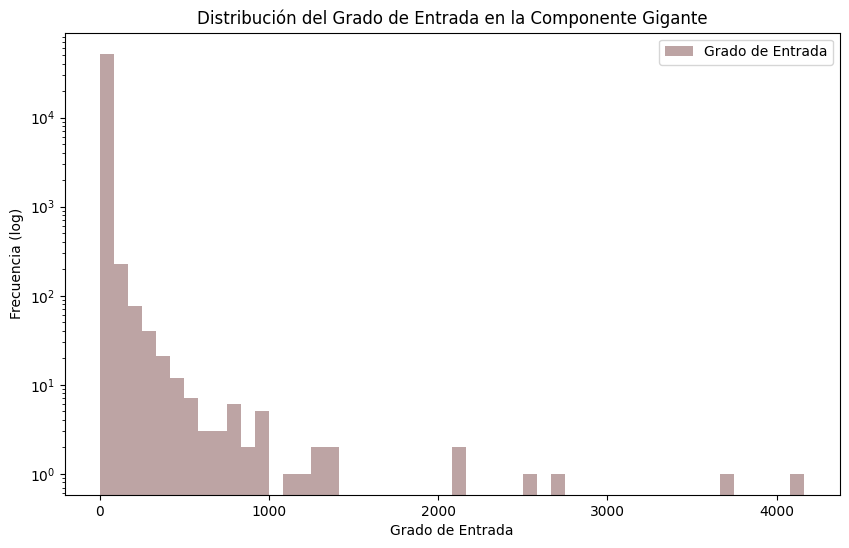

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(in_degree_values_giant, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Entrada')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Entrada en la Componente Gigante')
plt.xlabel('Grado de Entrada')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

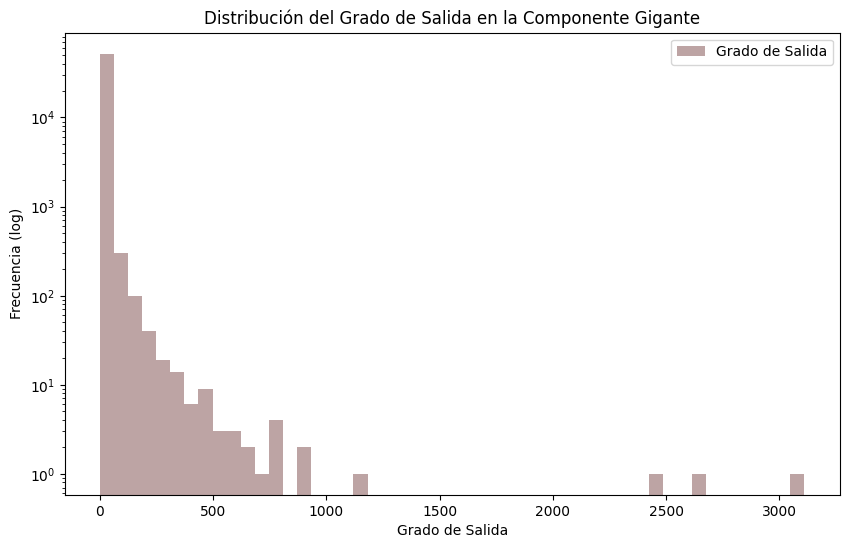

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(out_degree_values_giant, bins=50, log=True, alpha=0.5, color='#7D4A4B', label='Grado de Salida')  # Usamos escala logarítmica
plt.title('Distribución del Grado de Salida en la Componente Gigante')
plt.xlabel('Grado de Salida')
plt.ylabel('Frecuencia (log)')
plt.legend()
plt.show()

**Medidas de centralidad**

Centralidad de Grado

In [ ]:
# Calcular centralidad de grado
degree_centrality = nx.degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
# Obtener los 50 nodos más influyentes según la centralidad de grado
top_50_nodes_by_degree = sorted_degree_centrality[:50]

# Mostrar los 50 nodos más influyentes con su centralidad de grado
for node, centrality in top_50_nodes_by_degree:
    print(f"Nodo: {node}, Centralidad de Grado: {centrality}")

Nodo: askreddit, Centralidad de Grado: 0.0793641717651095
Nodo: iama, Centralidad de Grado: 0.07063487525492215
Nodo: bestof, Centralidad de Grado: 0.06680389578211067
Nodo: subredditdrama, Centralidad de Grado: 0.06283949911372863
Nodo: funny, Centralidad de Grado: 0.056988202107991694
Nodo: pics, Centralidad de Grado: 0.055444374559246765
Nodo: titlegore, Centralidad de Grado: 0.04745840242438104
Nodo: todayilearned, Centralidad de Grado: 0.04740122362627938
Nodo: videos, Centralidad de Grado: 0.044389806926258414
Nodo: gaming, Centralidad de Grado: 0.03945337069014809
Nodo: the_donald, Centralidad de Grado: 0.030095107400842435
Nodo: worldnews, Centralidad de Grado: 0.029370842624888028
Nodo: news, Centralidad de Grado: 0.028589399050831955
Nodo: wtf, Centralidad de Grado: 0.026988392703985363
Nodo: drama, Centralidad de Grado: 0.026683439114109822
Nodo: conspiracy, Centralidad de Grado: 0.026397545123601502
Nodo: gifs, Centralidad de Grado: 0.025425505555873217
Nodo: bitcoin, Centr

In [ ]:
# Calcular centralidad de grado de entrada
in_degree_centrality = nx.in_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de entrada
sorted_degree_centrality_in = sorted(in_degree_centrality.items(), key=lambda item: item[1], reverse=True)

# Calcular centralidad de grado de salida
out_degree_centrality = nx.out_degree_centrality(G1)
# Convertir en lista de tuplas (nodo, centralidad) y ordenar por centralidad de grado de salida
sorted_degree_centrality_out = sorted(out_degree_centrality.items(), key=lambda item: item[1], reverse=True)

Centralidad de Intermediación

In [ ]:
# Asumiendo que G es tu grafo dirigido
# k es el número de nodos de origen a utilizar en el cálculo
k = 1000

# Calcular la centralidad de intermediación aproximada
betweenness_centrality_approx = nx.betweenness_centrality(G1, k=k, normalized=True, endpoints=False)

# Ordenar los nodos por su centralidad de intermediación aproximada
sorted_betweenness_approx = sorted(betweenness_centrality_approx.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes según la centralidad de intermediación aproximada
top_50_nodes_by_betweenness_approx = sorted_betweenness_approx[:50]

# Imprimir los 50 nodos más influyentes con su centralidad de intermediación aproximada
for node, centrality in top_50_nodes_by_betweenness_approx:
    print(f"Nodo: {node}, Centralidad de Intermediación Aproximada: {centrality}")

Nodo: subredditdrama, Centralidad de Intermediación Aproximada: 0.040121355654091945
Nodo: bestof, Centralidad de Intermediación Aproximada: 0.03697489386193039
Nodo: gaming, Centralidad de Intermediación Aproximada: 0.028460230648577757
Nodo: funny, Centralidad de Intermediación Aproximada: 0.025812015803904072
Nodo: todayilearned, Centralidad de Intermediación Aproximada: 0.02338280189056344
Nodo: the_donald, Centralidad de Intermediación Aproximada: 0.01965798402682233
Nodo: pics, Centralidad de Intermediación Aproximada: 0.014711875022372242
Nodo: videos, Centralidad de Intermediación Aproximada: 0.014616648894462956
Nodo: bitcoin, Centralidad de Intermediación Aproximada: 0.014419291285985908
Nodo: news, Centralidad de Intermediación Aproximada: 0.011733414152739333
Nodo: conspiracy, Centralidad de Intermediación Aproximada: 0.011687964434167397
Nodo: worldnews, Centralidad de Intermediación Aproximada: 0.011239961271299415
Nodo: pcmasterrace, Centralidad de Intermediación Aproxim

Centralidad de Vector Propio

In [ ]:
# Calcular la centralidad de vector propio (eigenvector centrality)
eigenvector_dict = nx.eigenvector_centrality_numpy(G)

# Ordenar los nodos por su centralidad de vector propio
sorted_eigenvector = sorted(eigenvector_dict.items(), key=lambda item: item[1], reverse=True)

# Obtener los 50 nodos más influyentes
top_50_nodes_by_eigenvector = sorted_eigenvector[:50]

for node, centrality in top_50_nodes_by_eigenvector:
    print(f"Nodo: {node}, Centralidad de Vector Propio: {centrality}")

Nodo: iama, Centralidad de Vector Propio: 0.24569638104455457
Nodo: askreddit, Centralidad de Vector Propio: 0.23730673765789637
Nodo: pics, Centralidad de Vector Propio: 0.20119945444689952
Nodo: funny, Centralidad de Vector Propio: 0.19660559955746312
Nodo: videos, Centralidad de Vector Propio: 0.19293510444419826
Nodo: todayilearned, Centralidad de Vector Propio: 0.17628897880206523
Nodo: worldnews, Centralidad de Vector Propio: 0.14074774582598742
Nodo: gaming, Centralidad de Vector Propio: 0.1388214745786919
Nodo: news, Centralidad de Vector Propio: 0.13771827844820175
Nodo: gifs, Centralidad de Vector Propio: 0.12602668528435057
Nodo: science, Centralidad de Vector Propio: 0.12520913591816044
Nodo: wtf, Centralidad de Vector Propio: 0.11868289100637029
Nodo: the_donald, Centralidad de Vector Propio: 0.11149513624024644
Nodo: showerthoughts, Centralidad de Vector Propio: 0.11058266272872957
Nodo: movies, Centralidad de Vector Propio: 0.11019094600186839
Nodo: technology, Centralid

Pasamos de listas de tuplas a diccionarios para cada medida

In [ ]:
degree_centrality_in_dict = dict(sorted_degree_centrality_in)
degree_centrality_out_dict = dict(sorted_degree_centrality_out)
eigenvector_centrality_dict = dict(sorted_eigenvector)  # Asegúrate de tener esta lista de tuplas ordenada para eigenvector
#closeness_centrality_dict = dict(sorted_closeness)
betweenness_centrality_dict = dict(sorted_betweenness_approx)

Extraemos los valores de las medidas de centralidad en listas:

In [ ]:
degree_centrality_in_dict_values = list(degree_centrality_in_dict.values())
degree_centrality_out_dict_values = list(degree_centrality_out_dict.values())
eigenvector_centrality_dict_values = list(eigenvector_centrality_dict.values())  # Asegúrate de tener esta lista de tuplas ordenada para eigenvector
betweenness_centrality_dict_values = list(betweenness_centrality_dict.values())

In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_df = pd.DataFrame({
    'degree_in': pd.Series(degree_centrality_in_dict),
    'degree_out': pd.Series(degree_centrality_out_dict),
    'eigenvector': pd.Series(eigenvector_centrality_dict),
    #'closeness': pd.Series(closeness_centrality_dict),
    'betweenness': pd.Series(betweenness_centrality_dict)
})

Estadísticas Descriptivas

In [ ]:

descriptive_stats = centrality_df.describe()
print(descriptive_stats)

          degree_in    degree_out   eigenvector   betweenness
count  52468.000000  52468.000000  5.407500e+04  52468.000000
mean       0.000085      0.000085  6.734785e-04      0.000021
std        0.000812      0.000559  4.247304e-03      0.000389
min        0.000000      0.000000 -4.691737e-19      0.000000
25%        0.000000      0.000019 -1.578923e-21      0.000000
50%        0.000000      0.000019  1.384615e-20      0.000000
75%        0.000038      0.000038  1.497601e-04      0.000000
max        0.079364      0.059294  2.456964e-01      0.040121


El 75% de los nodos (percentil 25% al 75%) tienen centralidades extremadamente bajas, casi iguales a los mínimos, lo que refuerza la idea de una red con muchos nodos de poca importancia.

Los valores máximos (max) son mucho mayores que los percentiles 75%, destacando la presencia de unos pocos nodos altamente centrales o influyentes. Esto es particularmente notorio en la centralidad de eigenvector y betweenness.

Correlación entre las medidas de centralidad

In [ ]:
correlation_matrix = centrality_df.corr()
print(correlation_matrix)

             degree_in  degree_out  eigenvector  betweenness
degree_in     1.000000    0.291486     0.924830     0.602582
degree_out    0.291486    1.000000     0.359645     0.688779
eigenvector   0.924830    0.359645     1.000000     0.605399
betweenness   0.602582    0.688779     0.605399     1.000000


 Alta Correlación entre Grado y Eigenvector (0.856120):
los nodos con muchos enlaces (alto grado) tienden también a estar conectados con otros nodos bien conectados (alta centralidad de eigenvector). En términos prácticos, significa que los subreddits que tienen muchos otros subreddits enlazándolos (o a los que enlazan) también suelen estar en una posición central dentro de los grupos o comunidades más importantes de la red.

Correlación Moderada-Alta entre Grado y Betweenness (0.777703):
Los nodos con alta centralidad de grado también tienden a tener una alta centralidad de intermediación, pero la relación no es tan fuerte como con la centralidad de eigenvector. Esto sugiere que, aunque los nodos con muchos enlaces directos frecuentemente actúan como puentes importantes en la red (facilitando el flujo de información), la capacidad de actuar como intermediario no depende únicamente del número de conexiones.

Correlación Moderada entre Eigenvector y Betweenness (0.592318):
Esta correlación más baja indica que la importancia de un nodo como punto central dentro de su comunidad (alta centralidad de eigenvector) no siempre se traduce en actuar como un puente clave entre comunidades (alta centralidad de betweenness). Hay nodos que, a pesar de estar bien conectados dentro de sus propios grupos, no necesariamente conectan diferentes partes de la red.

# Análisis de Subred Política

In [ ]:
subreddits_politicos = [
    'politics', 'government', 'political', 'policy', 'governance', 'state', 'law', 'legislation',
    'congress', 'parliament', 'democracy', 'authoritarian', 'regime', 'electoral', 'election',
    'conservative', 'liberal', 'socialism', 'libertarian', 'communist', 'anarchism', 'progressive',
    'rightwing', 'leftwing', 'centrist', 'greenpolitics', 'feminism', 'republican', 'democrat',
    'gop', 'labour', 'tory', 'greens', 'teaParty', 'occupy', 'blacklivesmatter', 'antifa',
    'brexit', 'impeachment', 'referendum', 'climatechange', 'guncontrol',
    'healthcare', 'immigration', 'uspolitics', 'ukpolitics', 'europarl', 'middleeast', 'russia',
    'china', 'venezuela', 'syria', 'Israel', 'Palestine', 'war',
    #Añadiendo palabras relacionadas con Colombia y el capitalismo
    'colombia', 'colombian', 'farc', 'eln', 'peaceprocess', 'bogota', 'medellin',
    'capitalism', 'anticapitalism', 'neoliberalism', 'marxism', 'freeMarket', 'protest', 'strike',
    'paramilitary','guerilla','peaceagreement','privatization','tradeagreements', 'cali','humanrights',
    'latam', 'populism','debtcrisis', 'femicide','genderEquality','socialJustice','agrarianReform',
    'indigenousRights','patriarchy','machismo','economicReform','ruralDevelopment','socialMovements',
    'TLC','freeTrade','capitalismvsocialism','colombiapolitics', 'sudamerica','latinamericanpolitics',
    'leftvsright'
    #Ahora en español
    'politica','gobierno','politico','politicas','gobernanza','estado','ley','legislacion','congreso',
    'parlamento','democracia','autoritario','regimen','electoral','eleccion','conservador','liberal',
    'socialismo','libertario','comunista','anarquismo','progresista','derecha','izquierda','centrista',
    'politicaVerde','feminismo','republicano','democrata','GOP','laborista','conservadorReinoUnido',
    'verdes','TeaParty','ocupar','lasVidasNegrasImportan','antifa','eleccion','brexit','juicioPolitico',
    'referendum','cambioClimatico','controlDeArmas','atencionMedica','inmigracion','politicaEEUU',
    'politicaReinoUnido','parlamentoEuropeo','MedioOriente','Rusia','China','Venezuela','Siria','Israel',
    'Palestina','guerra',
    'Colombia','colombiano','FARC','ELN','procesoDePaz','Bogota','Medellin','capitalismo',
    'anticapitalismo','neoliberalismo','marxismo','libreMercado','protesta','huelga','paramilitar',
    'guerrilla','acuerdoDePaz','privatizacion','acuerdosComerciales','Cali','derechosHumanos',
    'AmericaLatina','populismo','crisisDeDeuda','feminicidio','igualdadDeGenero','justiciaSocial',
    'reformaAgraria','derechosIndigenas','patriarcado','machismo','reformaEconomica','desarrolloRural',
    'movimientosSociales','tratadoDeLibreComercio','libreComercio','capitalismovsSocialismo',
    'politicaColombiana','Sudamerica','politicaLatinoamericana','izquierdavsderecha'
]

In [ ]:
#Crear un subgrafo con solo los nodos de interés (que contienen las palabras clave)
subgraph_political = G.subgraph([node for node in G.nodes() if any(keyword in node.lower() for keyword in subreddits_politicos)])

len(subgraph_political)

1877

In [ ]:
densidad_sub = nx.density(subgraph_political)
print(f"Densidad del subgrafo: {densidad_sub}")

Densidad del subgrafo: 0.0004856227273708329


Medidas de centralidad

In [ ]:
# Centralidad de grado
degree_centrality_in = nx.in_degree_centrality(subgraph_political)

# Centralidad de grado
degree_centrality_out = nx.out_degree_centrality(subgraph_political)

# Centralidad de vector propio (eigenvector)
eigenvector_centrality = nx.eigenvector_centrality_numpy(subgraph_political)

# Centralidad de cercanía
closeness_centrality = nx.closeness_centrality(subgraph_political)

# Centralidad de betweenness (aproximada)
k = 200
betweenness_centrality = nx.betweenness_centrality(subgraph_political, k=k, normalized=True, endpoints=False)


In [ ]:
# Convertir los diccionarios en un DataFrame de pandas para facilitar el análisis
centrality_subgraph_df = pd.DataFrame({
    'sdegree_in': pd.Series(degree_centrality_in),
    'sdegree_out': pd.Series(degree_centrality_out),
    'seigenvector': pd.Series(eigenvector_centrality),
    'scloseness': pd.Series(closeness_centrality),
    'sbetweenness': pd.Series(betweenness_centrality)
})

In [ ]:

descriptive_stats = centrality_subgraph_df.describe()
print(descriptive_stats)

        sdegree_in  sdegree_out  seigenvector   scloseness  sbetweenness
count  1877.000000  1877.000000  1.877000e+03  1877.000000   1877.000000
mean      0.000486     0.000486  5.228598e-03     0.011647      0.000065
std       0.002437     0.002002  2.248769e-02     0.025358      0.000617
min       0.000000     0.000000 -7.896086e-18     0.000000      0.000000
25%       0.000000     0.000000 -1.014309e-18     0.000000      0.000000
50%       0.000000     0.000000  4.642975e-19     0.000000      0.000000
75%       0.000000     0.000533  2.037014e-18     0.000000      0.000000
max       0.058102     0.032516  3.139217e-01     0.109716      0.014595


In [ ]:
correlation_matrix = centrality_subgraph_df.corr()
print(correlation_matrix)

              sdegree_in  sdegree_out  seigenvector  scloseness  sbetweenness
sdegree_in      1.000000     0.686483      0.913368    0.483753      0.885533
sdegree_out     0.686483     1.000000      0.693279    0.395026      0.712895
seigenvector    0.913368     0.693279      1.000000    0.617027      0.758686
scloseness      0.483753     0.395026      0.617027    1.000000      0.317979
sbetweenness    0.885533     0.712895      0.758686    0.317979      1.000000


In [ ]:
# Calcular las medias de las centralidades
avg_degree_centrality = sum(degree_centrality.values()) / len(degree_centrality)
avg_eigenvector_centrality = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)
avg_closeness_centrality = sum(closeness_centrality.values()) / len(closeness_centrality)
avg_betweenness_centrality = sum(betweenness_centrality.values()) / len(betweenness_centrality)

# Imprimir las medias de las centralidades
print(f"Centralidad de Grado Promedio: {avg_degree_centrality}")
print(f"Centralidad de Vector Propio Promedio: {avg_eigenvector_centrality}")
print(f"Centralidad de Cercanía Promedio: {avg_closeness_centrality}")
print(f"Centralidad de Betweenness Promedio: {avg_betweenness_centrality}")

Centralidad de Grado Promedio: 0.00016994022369392757
Centralidad de Vector Propio Promedio: 0.005228597708322631
Centralidad de Cercanía Promedio: 0.011646801601692817
Centralidad de Betweenness Promedio: 6.513717128642502e-05


In [ ]:
# Función para imprimir los top N nodos más influyentes según una medida de centralidad
def print_top_n_nodes(centrality_dict, n=20, centrality_name="Centralidad"):
    sorted_nodes = sorted(centrality_dict.items(), key=lambda item: item[1], reverse=True)[:n]
    print(f"Top {n} nodos por {centrality_name}:")
    for i, (node, centrality_value) in enumerate(sorted_nodes, 1):
        print(f"{i}. Nodo: {node}, {centrality_name}: {centrality_value}")
    print("\n")  # Añadir una línea en blanco para separar las listas

# Imprimir los 20 nodos más influyentes según la centralidad de grado
print_top_n_nodes(degree_centrality, 40, "Centralidad de Grado")

# Imprimir los 20 nodos más influyentes según la centralidad de vector propio
print_top_n_nodes(eigenvector_centrality, 40, "Centralidad de Vector Propio")

# Imprimir los 20 nodos más influyentes según la centralidad de cercanía
print_top_n_nodes(closeness_centrality, 40, "Centralidad de Cercanía")

# Imprimir los 20 nodos más influyentes según la centralidad de betweenness
print_top_n_nodes(betweenness_centrality, 40, "Centralidad de Betweenness")

Top 40 nodos por Centralidad de Grado:
1. Nodo: askreddit, Centralidad de Grado: 0.0793641717651095
2. Nodo: iama, Centralidad de Grado: 0.07063487525492215
3. Nodo: bestof, Centralidad de Grado: 0.06680389578211067
4. Nodo: subredditdrama, Centralidad de Grado: 0.06283949911372863
5. Nodo: funny, Centralidad de Grado: 0.056988202107991694
6. Nodo: pics, Centralidad de Grado: 0.055444374559246765
7. Nodo: titlegore, Centralidad de Grado: 0.04745840242438104
8. Nodo: todayilearned, Centralidad de Grado: 0.04740122362627938
9. Nodo: videos, Centralidad de Grado: 0.044389806926258414
10. Nodo: gaming, Centralidad de Grado: 0.03945337069014809
11. Nodo: the_donald, Centralidad de Grado: 0.030095107400842435
12. Nodo: worldnews, Centralidad de Grado: 0.029370842624888028
13. Nodo: news, Centralidad de Grado: 0.028589399050831955
14. Nodo: wtf, Centralidad de Grado: 0.026988392703985363
15. Nodo: drama, Centralidad de Grado: 0.026683439114109822
16. Nodo: conspiracy, Centralidad de Grado: 0.

In [ ]:
# Función para convertir todos los atributos a string
def convert_attributes_to_string(G):
    for node, attrs in G.nodes(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G.nodes[node][attr] = str(value)
    for source, target, attrs in G.edges(data=True):
        for attr, value in attrs.items():
            # Convertir el valor del atributo a string
            G[source][target][attr] = str(value)

# Copia del subgrafo para no modificar el original
subgraph_political_copy = subgraph_political.copy()

# Convertir todos los atributos del subgrafo a string
convert_attributes_to_string(subgraph_political_copy)

# Ruta de acceso para guardar el archivo
output_file_path = '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political.gexf'

# Guardar el grafo en formato GEXF
nx.write_gexf(subgraph_political_copy, output_file_path)

Componente gigante del subgrafo

In [ ]:
# Encontrar las componentes conectadas (si el grafo es no dirigido) o fuertemente conectadas (si es dirigido)
connected_components = list(nx.strongly_connected_components(subgraph_political))

# Encontrar la componente gigante (la de mayor tamaño)
giant_component = max(connected_components, key=len)

# Crear un subgrafo a partir de la componente gigante
subgraph_political_giant = subgraph_political.subgraph(giant_component).copy()

# Imprimir el número de nodos en la componente gigante
print(f"El número de nodos en la componente gigante es: {subgraph_political_giant.number_of_nodes()}")


El número de nodos en la componente gigante es: 202


In [ ]:
# Crear una copia de subgraph_political_giant con los atributos de tipo lista convertidos a cadenas
subgraph_political_giant_copy = subgraph_political_giant.copy()

for u, v, data in subgraph_political_giant_copy.edges(data=True):
    # Convertir 'post_properties' de lista a cadena de texto si es una lista
    if isinstance(data.get('post_properties'), list):
        data['post_properties'] = ','.join(map(str, data['post_properties']))

# Guardar el subgrafo subgraph_political_giant_copy en un archivo GraphML
nx.write_graphml(subgraph_political_giant_copy, '/content/drive/MyDrive/Inv. teórica/Base de Datos/subgraph_political_giant.graphml')


##Top nodos con sentimiento negativo

In [ ]:
# Asignar el atributo 'post_label' al nodo de salida de cada arista
for u, v, data in subgraph_political.edges(data=True):
    # Verificamos si la arista tiene el atributo 'post_label'
    post_label = data.get('post_label')

    if post_label is not None:
        # Asignamos el valor de 'post_label' al nodo de salida (source)
        subgraph_political.nodes[u]['post_label'] = post_label
        print(f"Nodo {u} asignado con post_label: {post_label}")


Nodo shitukpoliticssays asignado con post_label: 1
Nodo urbangop asignado con post_label: 1
Nodo urbangop asignado con post_label: 1
Nodo anarchismcirclejerk asignado con post_label: 1
Nodo californiasocialists asignado con post_label: 1
Nodo embarassedrepublican asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo warhammer asignado con post_label: 1
Nodo politicalrevolutionny asignado con post_label: 1
Nodo warframe asignado con post_label: 1
Nodo warframe asignado con post_label: 1
Nodo software_cracking asignado con post_label: 1
Nodo political_discussion asignado con post_label: 1
Nodo political_discussion asignado con post_label: 1
Nodo wargame asignado con post_label: 1
Nodo yescalifornia asignado con post_label: 1
Nodo mslibertarians asignado con post_label: 1
Nodo oregonlibertarians asignado

In [ ]:
import networkx as nx

# Calcular la centralidad de grado para todos los nodos en el subgrafo político
degree_centrality = nx.degree_centrality(subgraph_political)

# Filtrar los nodos que tienen un 'post_label' de -1
nodes_with_negative_post_label = [node for node, data in subgraph_political.nodes(data=True) if data.get('post_label') == -1]

# Filtrar los nodos que tienen un 'post_label' de -1 y calcular su centralidad de grado
degree_centrality_filtered = {node: degree_centrality[node] for node in nodes_with_negative_post_label}

# Ordenar los nodos por centralidad de grado de mayor a menor
sorted_nodes = sorted(degree_centrality_filtered.items(), key=lambda x: x[1], reverse=True)

# Obtener los 55 nodos más centrales
top_45_nodes = sorted_nodes[:55]

# Mostrar los nodos seleccionados
print("Top 45 nodos con mayor centralidad de grado y 'post_label = -1':")
for node, centrality in top_45_nodes:
    print(f"Node: {node}, Degree Centrality: {centrality}")


Top 45 nodos con mayor centralidad de grado y 'post_label = -1':
Node: panichistory, Degree Centrality: 0.013326226012793176
Node: california, Degree Centrality: 0.010127931769722815
Node: shitsocialismsays, Degree Centrality: 0.008528784648187633
Node: capitalismvsocialism, Degree Centrality: 0.008528784648187633
Node: libertarianbestof, Degree Centrality: 0.005863539445628998
Node: endlesswar, Degree Centrality: 0.004797441364605543
Node: nationalsocialism, Degree Centrality: 0.0037313432835820895
Node: australianpolitics, Degree Centrality: 0.0031982942430703624
Node: qualitysocialism, Degree Centrality: 0.0031982942430703624
Node: antifa, Degree Centrality: 0.0031982942430703624
Node: isrconservativeracist, Degree Centrality: 0.0026652452025586353
Node: rightwinglgbt, Degree Centrality: 0.0021321961620469083
Node: socialistsvsfeminism, Degree Centrality: 0.0015991471215351812
Node: liberalism, Degree Centrality: 0.0015991471215351812
Node: supcourtwesternstate, Degree Centrality: 0

#Modelo de cascada

In [ ]:
# Extraer solo los nombres de los nodos de las tuplas en top_45_nodes
top_45_node_names = [node for node, centrality in top_45_nodes]

# Verificar si los nodos están en G y en G1
nodes_in_G = [node for node in top_45_node_names if node in G.nodes()]
nodes_in_G1 = [node for node in top_45_node_names if node in G1.nodes()]

# Imprimir los resultados
print(f"Número de nodos de los 45 presentes en G: {len(nodes_in_G)}")
print(f"Número de nodos de los 45 presentes en G1: {len(nodes_in_G1)}")

# Mostrar los nodos que faltan en G o G1
nodes_not_in_G = [node for node in top_45_node_names if node not in G.nodes()]
nodes_not_in_G1 = [node for node in top_45_node_names if node not in G1.nodes()]

print(f"Nodos que faltan en G: {nodes_not_in_G}")
print(f"Nodos que faltan en G1: {nodes_not_in_G1}")


Número de nodos de los 45 presentes en G: 35
Número de nodos de los 45 presentes en G1: 35
Nodos que faltan en G: []
Nodos que faltan en G1: []


In [ ]:
print(f"Algunos nodos en top_45_nodes: {top_45_nodes[:5]}")
print(f"Algunos nodos en G: {list(G.nodes())[:5]}")
print(f"Algunos nodos en G1: {list(G1.nodes())[:5]}")


Algunos nodos en top_45_nodes: [('panichistory', 0.013326226012793176), ('california', 0.010127931769722815), ('shitsocialismsays', 0.008528784648187633), ('capitalismvsocialism', 0.008528784648187633), ('libertarianbestof', 0.005863539445628998)]
Algunos nodos en G: ['rddtgaming', 'rddtrust', 'xboxone', 'battlefield_4', 'ps4']
Algunos nodos en G1: ['rddtgaming', 'rddtrust', 'xboxone', 'battlefield_4', 'ps4']


##Para una probabilidad fija

In [ ]:
import random
import random
import networkx as nx

# Función para correr el modelo de cascada independiente
def independent_cascade(G, initial_nodes, prob_spread=0.1, steps=1000):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Propagar la ideología con probabilidad 'prob_spread'
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return activated  # Retorna el conjunto de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente en el grafo G1
result = independent_cascade(G1, initial_nodes, prob_spread=0.1, steps=1000)

# Mostrar el número de nodos activados por la ideología
print(f"Nodos que adoptaron la ideología: {len(result)}")


Nodos que adoptaron la ideología: 4543


In [ ]:
# Función para correr el modelo de cascada independiente
def independent_cascade(G, initial_nodes, prob_spread=0.1, steps=1000):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Propagar la ideología con probabilidad 'prob_spread'
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return activated  # Retorna el conjunto de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Valores de probabilidad de propagación (de 0.1 a 1 con paso de 0.1)
prob_values = [i/10 for i in range(1, 11)]

# Lista para guardar el número de nodos activados para cada probabilidad
num_activated_nodes = []

# Ejecutar el modelo para cada probabilidad de propagación
for prob in prob_values:
    result = independent_cascade(G1, initial_nodes, prob_spread=prob, steps=1000)
    num_activated_nodes.append(len(result))


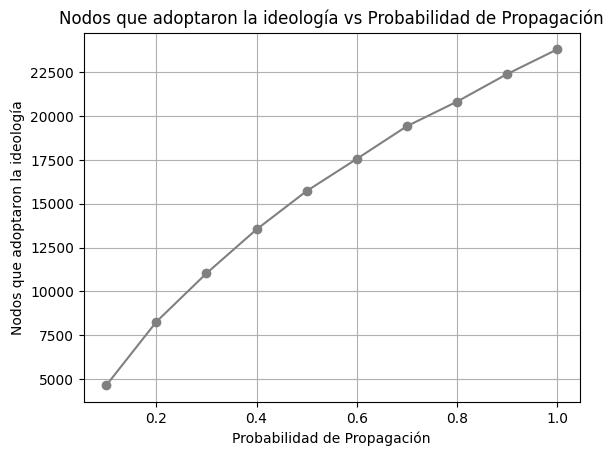

In [ ]:
import matplotlib.pyplot as plt

# Crear el gráfico con puntos y líneas en color gris
plt.plot(prob_values, num_activated_nodes, marker='o', color='gray')

# Configurar el título, las etiquetas y la cuadrícula como predeterminadas
plt.title("Nodos que adoptaron la ideología vs Probabilidad de Propagación")
plt.xlabel("Probabilidad de Propagación")
plt.ylabel("Nodos que adoptaron la ideología")
plt.grid(True)

# Mostrar el gráfico
plt.show()


##Para una probabilidad random

In [ ]:
# Función para correr el modelo de cascada independiente con probabilidad aleatoria
def independent_cascade_random_prob(G, initial_nodes, min_prob=0.0, max_prob=1.0, steps=1000):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Generar una probabilidad aleatoria para cada vecino
                    prob_spread = random.uniform(min_prob, max_prob)

                    # Propagar la ideología con la probabilidad aleatoria
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return activated  # Retorna el conjunto de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente en el grafo G1 con probabilidad aleatoria
result_random = independent_cascade_random_prob(G1, initial_nodes, min_prob=0.0, max_prob=1.0, steps=1000)

# Mostrar el número de nodos activados por la ideología
print(f"Nodos que adoptaron la ideología: {len(result_random)}")


Nodos que adoptaron la ideología: 15765


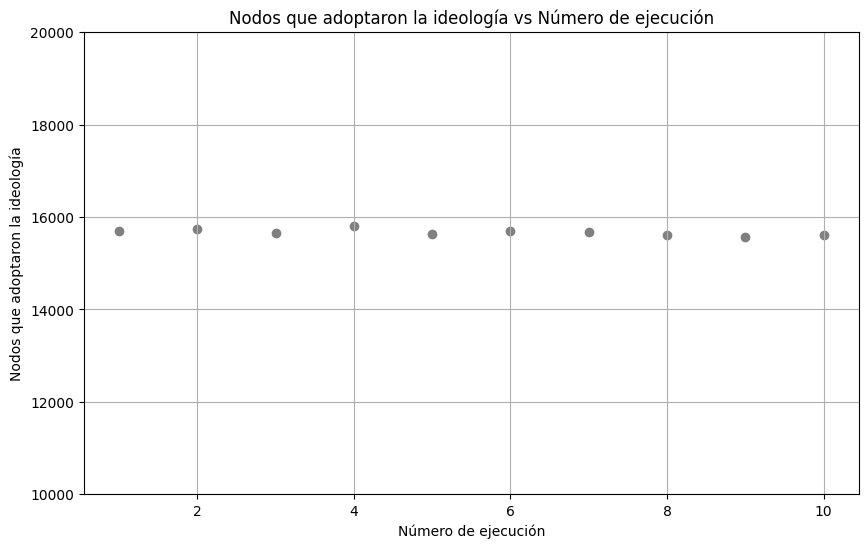

In [ ]:
def independent_cascade_random_prob(G, initial_nodes, min_prob=0.0, max_prob=1.0, steps=1000):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Generar una probabilidad aleatoria para cada vecino
                    prob_spread = random.uniform(min_prob, max_prob)

                    # Propagar la ideología con la probabilidad aleatoria
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return len(activated)  # Retorna el número total de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente 10 veces y almacenar los resultados
activations_per_execution = []
for i in range(10):
    result = independent_cascade_random_prob(G1, initial_nodes, min_prob=0.0, max_prob=1.0, steps=1000)
    activations_per_execution.append(result)

# Crear la gráfica de "nodos que adoptaron la ideología" vs "número de ejecución"
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 11), activations_per_execution, color='gray', marker='o')  # Usar scatter para solo puntos

# Configurar el rango del eje Y de 10000 a 20000
plt.ylim(10000, 20000)

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología vs Número de ejecución")
plt.xlabel("Número de ejecución")
plt.ylabel("Nodos que adoptaron la ideología")
plt.grid(True)

# Mostrar la gráfica
plt.show()


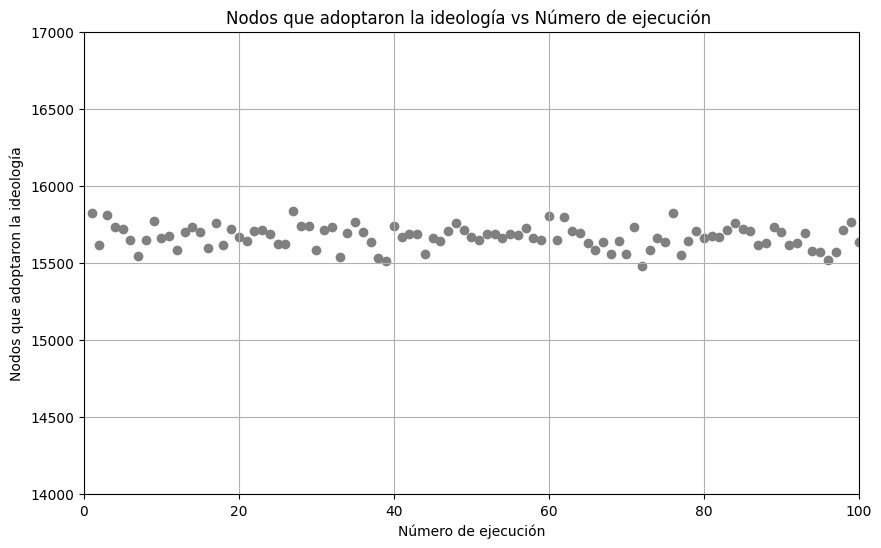

In [ ]:
def independent_cascade_random_prob(G, initial_nodes, min_prob=0.0, max_prob=1.0, steps=10):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Generar una probabilidad aleatoria para cada vecino
                    prob_spread = random.uniform(min_prob, max_prob)

                    # Propagar la ideología con la probabilidad aleatoria
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return len(activated)  # Retorna el número total de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente 100 veces y almacenar los resultados
activations_per_execution = []
for i in range(100):
    result = independent_cascade_random_prob(G1, initial_nodes, min_prob=0.0, max_prob=1.0, steps=10)
    activations_per_execution.append(result)

# Crear la gráfica de "nodos que adoptaron la ideología" vs "número de ejecución"
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 101), activations_per_execution, color='gray', marker='o')  # Usar scatter con color gris

# Configurar el rango del eje X de 0 a 100
plt.xlim(0, 100)

# Configurar el rango del eje Y de 10000 a 20000
plt.ylim(14000, 17000)

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología vs Número de ejecución ")
plt.xlabel("Número de ejecución")
plt.ylabel("Nodos que adoptaron la ideología")
plt.grid(True)

# Mostrar la gráfica
plt.show()


##Probabilidad condicionada según el post_label

In [ ]:
# Función para correr el modelo de cascada independiente con probabilidad condicionada por el valor de POST_LABEL
def independent_cascade_post_label_prob(G, initial_nodes, steps=10):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Obtener el valor de post_label en el enlace que conecta 'node' con 'neighbor'
                    post_label = G.edges[node, neighbor]['post_label']

                    # Establecer la probabilidad de propagación basada en el valor de post_label
                    if post_label == 1:
                        prob_spread = random.uniform(0.0, 0.49)
                    elif post_label == 0:
                        prob_spread = 0.5
                    elif post_label == -1:
                        prob_spread = random.uniform(0.51, 1.0)

                    # Propagar la ideología con la probabilidad definida
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return len(activated)  # Retorna el número total de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente una vez
result_cond = independent_cascade_post_label_prob(G1, initial_nodes, steps=10)

# Imprimir el número de nodos que adoptaron la ideología
print(f"Número de nodos que adoptaron la ideología: {result_cond}")


Número de nodos que adoptaron la ideología: 10450


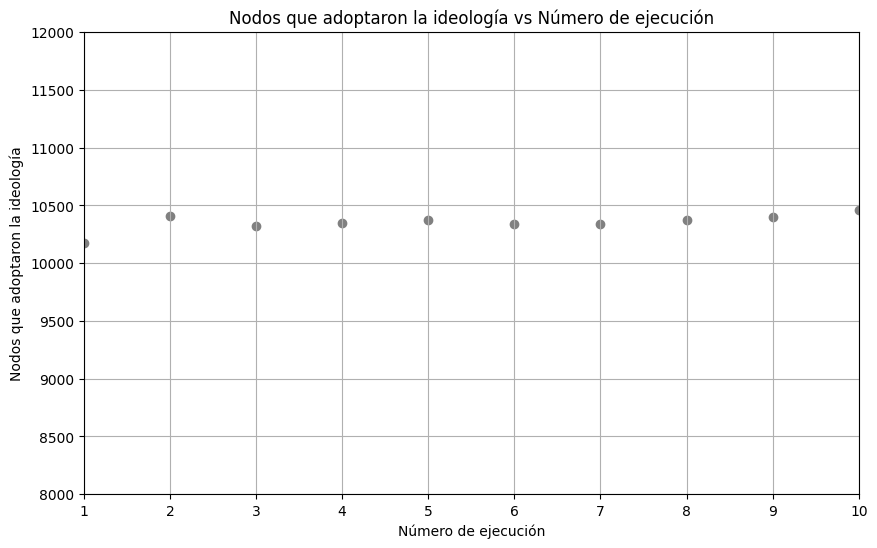

In [ ]:
# Función para correr el modelo de cascada independiente con probabilidad condicionada por el valor de POST_LABEL
def independent_cascade_post_label_prob(G, initial_nodes, steps=10):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Obtener el valor de post_label en el enlace que conecta 'node' con 'neighbor'
                    post_label = G.edges[node, neighbor]['post_label']

                    # Establecer la probabilidad de propagación basada en el valor de post_label
                    if post_label == 1:
                        prob_spread = random.uniform(0.0, 0.49)
                    elif post_label == 0:
                        prob_spread = 0.5
                    elif post_label == -1:
                        prob_spread = random.uniform(0.51, 1.0)

                    # Propagar la ideología con la probabilidad definida
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return len(activated)  # Retorna el número total de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente 10 veces y almacenar los resultados
activations_per_execution = []
for i in range(10):
    result = independent_cascade_post_label_prob(G1, initial_nodes, steps=10)
    activations_per_execution.append(result)

# Crear la gráfica de "nodos que adoptaron la ideología" vs "número de ejecución"
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 11), activations_per_execution, color='gray', marker='o')  # Usar scatter con color gris

# Configurar el rango de los ejes
plt.xlim(1, 10)
plt.ylim(8000, 12000)

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología vs Número de ejecución")
plt.xlabel("Número de ejecución")
plt.ylabel("Nodos que adoptaron la ideología")
plt.grid(True)

# Mostrar la gráfica
plt.show()


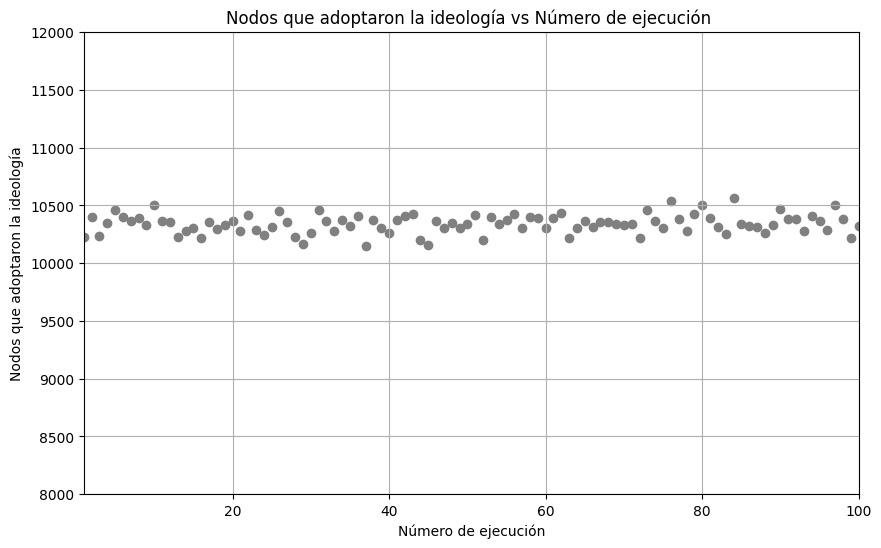

In [ ]:
def independent_cascade_post_label_prob(G, initial_nodes, steps=10):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Obtener el valor de post_label en el enlace que conecta 'node' con 'neighbor'
                    post_label = G.edges[node, neighbor]['post_label']

                    # Establecer la probabilidad de propagación basada en el valor de post_label
                    if post_label == 1:
                        prob_spread = random.uniform(0.0, 0.49)
                    elif post_label == 0:
                        prob_spread = 0.5
                    elif post_label == -1:
                        prob_spread = random.uniform(0.51, 1.0)

                    # Propagar la ideología con la probabilidad definida
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return len(activated)  # Retorna el número total de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente 100 veces y almacenar los resultados
activations_per_execution = []
for i in range(100):
    result = independent_cascade_post_label_prob(G1, initial_nodes, steps=10)
    activations_per_execution.append(result)

# Crear la gráfica de "nodos que adoptaron la ideología" vs "número de ejecución"
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 101), activations_per_execution, color='gray', marker='o')  # Usar scatter con color gris

# Configurar el rango del eje X de 1 a 100
plt.xlim(1, 100)

# Configurar el rango del eje Y de 5000 a 15000
plt.ylim(8000, 12000)

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología vs Número de ejecución ")
plt.xlabel("Número de ejecución")
plt.ylabel("Nodos que adoptaron la ideología")
plt.grid(True)

# Mostrar la gráfica
plt.show()


------------------------


#Caracterización de comunidades


In [ ]:
pip install python-louvain

In [ ]:
import community.community_louvain as community_louvain


In [ ]:
# Convertir el grafo dirigido G1 a no dirigido
G1_undirected = G1.to_undirected()

# Detección de comunidades usando Louvain en el grafo no dirigido
partition = community_louvain.best_partition(G1_undirected)  # Retorna un diccionario {nodo: comunidad}

# Verificar cuántas comunidades se encontraron
num_communities = len(set(partition.values()))
print(f"Número de comunidades encontradas: {num_communities}")


Número de comunidades encontradas: 66


In [ ]:
from collections import defaultdict

# Agrupar los nodos por comunidad
communities = defaultdict(list)
for node, community in partition.items():
    communities[community].append(node)

# Mostrar cuántos nodos hay en cada comunidad
for community, nodes in communities.items():
    print(f"Comunidad {community} tiene {len(nodes)} nodos")


Comunidad 0 tiene 4429 nodos
Comunidad 1 tiene 4970 nodos
Comunidad 2 tiene 2560 nodos
Comunidad 3 tiene 835 nodos
Comunidad 4 tiene 1871 nodos
Comunidad 5 tiene 8607 nodos
Comunidad 6 tiene 3784 nodos
Comunidad 7 tiene 6989 nodos
Comunidad 8 tiene 4742 nodos
Comunidad 40 tiene 1465 nodos
Comunidad 10 tiene 1336 nodos
Comunidad 16 tiene 1140 nodos
Comunidad 12 tiene 943 nodos
Comunidad 13 tiene 1061 nodos
Comunidad 28 tiene 884 nodos
Comunidad 15 tiene 456 nodos
Comunidad 19 tiene 1902 nodos
Comunidad 24 tiene 467 nodos
Comunidad 18 tiene 329 nodos
Comunidad 21 tiene 1609 nodos
Comunidad 23 tiene 149 nodos
Comunidad 26 tiene 293 nodos
Comunidad 36 tiene 492 nodos
Comunidad 32 tiene 318 nodos
Comunidad 33 tiene 3 nodos
Comunidad 34 tiene 330 nodos
Comunidad 35 tiene 4 nodos
Comunidad 37 tiene 7 nodos
Comunidad 38 tiene 9 nodos
Comunidad 39 tiene 4 nodos
Comunidad 41 tiene 3 nodos
Comunidad 30 tiene 251 nodos
Comunidad 44 tiene 3 nodos
Comunidad 45 tiene 3 nodos
Comunidad 46 tiene 3 nodo

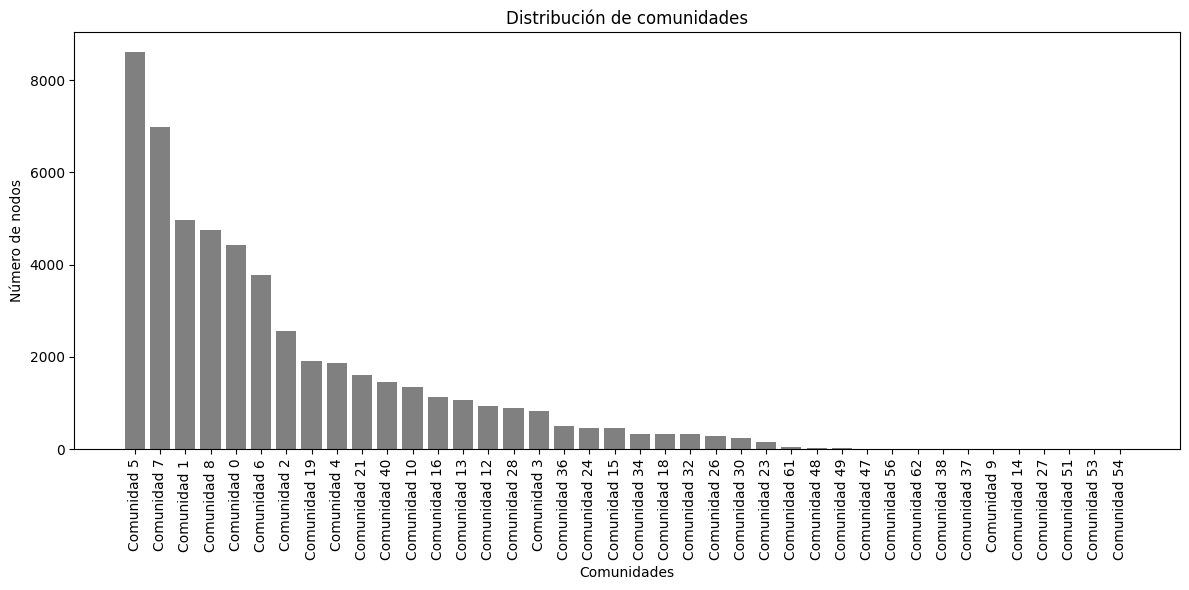

In [ ]:
import matplotlib.pyplot as plt

# Lista de comunidades y el número de nodos
comunidades_data = {
    'Comunidad 0': 4429, 'Comunidad 1': 4970, 'Comunidad 2': 2560, 'Comunidad 3': 835, 'Comunidad 4': 1871, 'Comunidad 5': 8607,
    'Comunidad 6': 3784, 'Comunidad 7': 6989, 'Comunidad 8': 4742, 'Comunidad 40': 1465, 'Comunidad 10': 1336, 'Comunidad 16': 1140,
    'Comunidad 12': 943, 'Comunidad 13': 1061, 'Comunidad 28': 884, 'Comunidad 15': 456, 'Comunidad 19': 1902, 'Comunidad 24': 467,
    'Comunidad 18': 329, 'Comunidad 21': 1609, 'Comunidad 23': 149, 'Comunidad 26': 293, 'Comunidad 36': 492, 'Comunidad 32': 318,
    'Comunidad 33': 3, 'Comunidad 34': 330, 'Comunidad 35': 4, 'Comunidad 37': 7, 'Comunidad 38': 9, 'Comunidad 39': 4,
    'Comunidad 41': 3, 'Comunidad 30': 251, 'Comunidad 44': 3, 'Comunidad 45': 3, 'Comunidad 46': 3, 'Comunidad 47': 12,
    'Comunidad 48': 27, 'Comunidad 49': 15, 'Comunidad 50': 3, 'Comunidad 51': 5, 'Comunidad 52': 4, 'Comunidad 53': 5,
    'Comunidad 54': 5, 'Comunidad 55': 3, 'Comunidad 56': 11, 'Comunidad 57': 3, 'Comunidad 58': 3, 'Comunidad 59': 4,
    'Comunidad 60': 4, 'Comunidad 61': 45, 'Comunidad 62': 10, 'Comunidad 63': 3, 'Comunidad 64': 3, 'Comunidad 65': 4,
    'Comunidad 9': 6, 'Comunidad 42': 3, 'Comunidad 11': 4, 'Comunidad 43': 3, 'Comunidad 14': 6, 'Comunidad 17': 3,
    'Comunidad 20': 3, 'Comunidad 22': 3, 'Comunidad 25': 4, 'Comunidad 27': 6, 'Comunidad 29': 3, 'Comunidad 31': 4
}

# Ordenar las comunidades por número de nodos (de mayor a menor)
sorted_communities = sorted(comunidades_data.items(), key=lambda x: x[1], reverse=True)

# Seleccionar solo las 40 primeras comunidades
top_40_communities = sorted_communities[:40]

# Separar los nombres de las comunidades y el número de nodos
comunidades_ordenadas = [item[0] for item in top_40_communities]
nodos_ordenados = [item[1] for item in top_40_communities]

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
plt.bar(comunidades_ordenadas, nodos_ordenados, color='gray')
plt.xticks(rotation=90)
plt.xlabel('Comunidades')
plt.ylabel('Número de nodos')
plt.title('Distribución de comunidades')
plt.tight_layout()
plt.show()


##Caracterización de los nodos iniciales

In [ ]:
# Verificar a qué comunidad pertenece cada uno de los 45 nodos más influyentes
top_45_communities = {node: partition[node] for node in top_45_node_names if node in partition}

# Imprimir la comunidad de cada nodo
for node, community in top_45_communities.items():
    print(f"El nodo {node} pertenece a la comunidad {community}")


El nodo panichistory pertenece a la comunidad 7
El nodo california pertenece a la comunidad 6
El nodo shitsocialismsays pertenece a la comunidad 7
El nodo capitalismvsocialism pertenece a la comunidad 7
El nodo libertarianbestof pertenece a la comunidad 7
El nodo endlesswar pertenece a la comunidad 7
El nodo nationalsocialism pertenece a la comunidad 7
El nodo australianpolitics pertenece a la comunidad 7
El nodo qualitysocialism pertenece a la comunidad 7
El nodo antifa pertenece a la comunidad 7
El nodo isrconservativeracist pertenece a la comunidad 7
El nodo rightwinglgbt pertenece a la comunidad 7
El nodo socialistsvsfeminism pertenece a la comunidad 7
El nodo liberalism pertenece a la comunidad 7
El nodo supcourtwesternstate pertenece a la comunidad 30
El nodo farcraft1 pertenece a la comunidad 7
El nodo bestofconservative pertenece a la comunidad 7
El nodo bannedfromsocialism pertenece a la comunidad 7
El nodo liberalviolence pertenece a la comunidad 7
El nodo politicaldiscussmet

In [ ]:
from collections import Counter

# Contar cuántos de los 45 nodos pertenecen a cada comunidad
community_counts = Counter(top_45_communities.values())

# Imprimir los resultados
print("Distribución de los 35 nodos más centrales entre comunidades:")
for community, count in community_counts.items():
    print(f"Comunidad {community}: {count} nodos")


Distribución de los 35 nodos más centrales entre comunidades:
Comunidad 7: 26 nodos
Comunidad 6: 2 nodos
Comunidad 30: 1 nodos
Comunidad 5: 4 nodos
Comunidad 21: 1 nodos
Comunidad 0: 1 nodos


In [ ]:
from collections import defaultdict

# Crear un diccionario para almacenar los valores de 'POST_PROPERTIES' por comunidad
community_properties = defaultdict(list)

# Iterar sobre cada comunidad y sus nodos
for community, nodes in communities.items():
    # Para cada nodo, obtener los enlaces y sus propiedades
    for node in nodes:
        # Obtener todos los enlaces de salida (dirigidos) desde este nodo
        for target_node in G1.successors(node):
            # Verificar si el enlace tiene 'post_properties'
            if 'post_properties' in G1[node][target_node]:  # Las propiedades están en el enlace
                properties = G1[node][target_node]['post_properties']  # Extraer el vector de propiedades
                community_properties[community].append(properties)

# Convertir a numpy arrays para facilitar el cálculo de estadísticas
for community in community_properties:
    if community_properties[community]:  # Asegurarse de que hay datos
        community_properties[community] = np.array(community_properties[community])


In [ ]:
# Calcular la media de cada propiedad en cada comunidad
for community, properties_matrix in community_properties.items():
    if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
        # Calcular la media, mediana y desviación estándar para cada columna (cada propiedad)
        mean_properties = np.mean(properties_matrix, axis=0)
        median_properties = np.median(properties_matrix, axis=0)
        std_properties = np.std(properties_matrix, axis=0)

        # Formatear los resultados con 4 cifras decimales
        mean_properties = np.around(mean_properties, 4)
        median_properties = np.around(median_properties, 4)
        std_properties = np.around(std_properties, 4)

        # Imprimir los resultados formateados
        print(f"Comunidad {community}:")
        print(f"  Media de las propiedades: {mean_properties}")
        print(f"  Mediana de las propiedades: {median_properties}")
        print(f"  Desviación estándar de las propiedades: {std_properties}")
        print()


Comunidad 0:
  Media de las propiedades: [71.8296 62.1258  0.7788  0.0101  0.1788  0.1445  0.0665 12.2879 11.9165
  2.4083  4.7459  2.7328  0.202   1.2998  0.466  58.4479 10.0044 11.7362
  0.0866  0.0511  0.0669  0.245   0.0446  0.0226  0.0104  0.0045  0.0044
  0.002   0.0018  0.0221  0.0348  0.0577  0.0319  0.0121  0.0373  0.0039
  0.0189  0.0863  0.0173  0.0037  0.0128  0.0043  0.0019  0.0497  0.0013
  0.0012  0.005   0.0424  0.0285  0.014   0.0009  0.0084  0.0018  0.0766
  0.0141  0.0116  0.0069  0.0135  0.0052  0.0032  0.0184  0.0083  0.0113
  0.0058  0.0021  0.0026  0.0082  0.0027  0.0027  0.0019  0.0013  0.0987
  0.0101  0.04    0.0343  0.0157  0.0152  0.0233  0.0016  0.0078  0.0022
  0.0021  0.0026  0.0014  0.0006  0.0016]
  Mediana de las propiedades: [64.     56.      0.785   0.      0.1532  0.1458  0.0606 11.     11.
  2.      4.625   2.      0.2     1.      0.     53.      9.     11.4
  0.      0.      0.      0.25    0.      0.      0.      0.      0.
  0.      0.      0.  

In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. Positive sentiment calculated by VADER:")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 18  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 19. Positive sentiment calculated by VADER:
Comunidad: 17
  Media: 0.3843
  Mediana: 0.3850
  Desviación estándar: 0.0009

Comunidad: 31
  Media: 0.2255
  Mediana: 0.1925
  Desviación estándar: 0.1858

Comunidad: 47
  Media: 0.2158
  Mediana: 0.2590
  Desviación estándar: 0.0965

Comunidad: 57
  Media: 0.2140
  Mediana: 0.2140
  Desviación estándar: 0.2140

Comunidad: 37
  Media: 0.1929
  Mediana: 0.2700
  Desviación estándar: 0.1220



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. Negative sentiment calculated by VADER:")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 19  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 20. Negative sentiment calculated by VADER:
Comunidad: 46
  Media: 0.4920
  Mediana: 0.4920
  Desviación estándar: 0.1820

Comunidad: 55
  Media: 0.3610
  Mediana: 0.3610
  Desviación estándar: 0.3610

Comunidad: 29
  Media: 0.2323
  Mediana: 0.2070
  Desviación estándar: 0.0812

Comunidad: 31
  Media: 0.2303
  Mediana: 0.2320
  Desviación estándar: 0.1616

Comunidad: 34
  Media: 0.1520
  Mediana: 0.0000
  Desviación estándar: 0.1905



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. COmpound sentiment calculated by VADER:")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()

atributo_a_analizar = 20  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 21. COmpound sentiment calculated by VADER:
Comunidad: 17
  Media: 0.3997
  Mediana: 0.3612
  Desviación estándar: 0.0544

Comunidad: 47
  Media: 0.3513
  Mediana: 0.4215
  Desviación estándar: 0.1571

Comunidad: 59
  Media: 0.2936
  Mediana: 0.4404
  Desviación estándar: 0.2076

Comunidad: 42
  Media: 0.2752
  Mediana: 0.2263
  Desviación estándar: 0.2471

Comunidad: 37
  Media: 0.2716
  Mediana: 0.3802
  Desviación estándar: 0.1718



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Swear (malas palabras):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 42  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 43. LIWC_Swear (malas palabras):
Comunidad: 38
  Media: 0.0091
  Mediana: 0.0000
  Desviación estándar: 0.0235

Comunidad: 21
  Media: 0.0088
  Mediana: 0.0000
  Desviación estándar: 0.0342

Comunidad: 1
  Media: 0.0053
  Mediana: 0.0000
  Desviación estándar: 0.0224

Comunidad: 5
  Media: 0.0042
  Mediana: 0.0000
  Desviación estándar: 0.0235

Comunidad: 13
  Media: 0.0037
  Mediana: 0.0000
  Desviación estándar: 0.0235



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Social (Palabras relacionadas con interacciones sociales):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 43  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 44. LIWC_Social (Palabras relacionadas con interacciones sociales):
Comunidad: 64
  Media: 0.1143
  Mediana: 0.1429
  Desviación estándar: 0.0841

Comunidad: 27
  Media: 0.1093
  Mediana: 0.1333
  Desviación estándar: 0.0407

Comunidad: 58
  Media: 0.0909
  Mediana: 0.0909
  Desviación estándar: 0.0000

Comunidad: 38
  Media: 0.0843
  Mediana: 0.0578
  Desviación estándar: 0.0902

Comunidad: 54
  Media: 0.0784
  Mediana: 0.0833
  Desviación estándar: 0.0409



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Family(Palabras relacionadas con la familia).:")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 44  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 45. LIWC_Family(Palabras relacionadas con la familia).:
Comunidad: 38
  Media: 0.0063
  Mediana: 0.0000
  Desviación estándar: 0.0143

Comunidad: 1
  Media: 0.0035
  Mediana: 0.0000
  Desviación estándar: 0.0177

Comunidad: 48
  Media: 0.0029
  Mediana: 0.0000
  Desviación estándar: 0.0152

Comunidad: 24
  Media: 0.0027
  Mediana: 0.0000
  Desviación estándar: 0.0173

Comunidad: 62
  Media: 0.0023
  Mediana: 0.0000
  Desviación estándar: 0.0070



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Affect (Palabras relacionadas con emociones):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()

atributo_a_analizar = 47  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 48. LIWC_Affect (Palabras relacionadas con emociones):
Comunidad: 31
  Media: 0.1667
  Mediana: 0.1623
  Desviación estándar: 0.0339

Comunidad: 55
  Media: 0.1482
  Mediana: 0.1714
  Desviación estándar: 0.0936

Comunidad: 57
  Media: 0.1429
  Mediana: 0.1429
  Desviación estándar: 0.0000

Comunidad: 17
  Media: 0.1369
  Mediana: 0.1429
  Desviación estándar: 0.0084

Comunidad: 51
  Media: 0.0980
  Mediana: 0.0294
  Desviación estándar: 0.1380



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Posemo(Palabras relacionadas con emociones positivas):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 48  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 49. LIWC_Posemo(Palabras relacionadas con emociones positivas):
Comunidad: 57
  Media: 0.1429
  Mediana: 0.1429
  Desviación estándar: 0.0000

Comunidad: 17
  Media: 0.1369
  Mediana: 0.1429
  Desviación estándar: 0.0084

Comunidad: 51
  Media: 0.0980
  Mediana: 0.0294
  Desviación estándar: 0.1380

Comunidad: 31
  Media: 0.0869
  Mediana: 0.0667
  Desviación estándar: 0.0803

Comunidad: 47
  Media: 0.0758
  Mediana: 0.0909
  Desviación estándar: 0.0339



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Negemo(Palabras relacionadas con emociones negativas):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 49  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 50. LIWC_Negemo(Palabras relacionadas con emociones negativas):
Comunidad: 55
  Media: 0.1125
  Mediana: 0.1000
  Desviación estándar: 0.1139

Comunidad: 31
  Media: 0.0797
  Mediana: 0.0880
  Desviación estándar: 0.0512

Comunidad: 46
  Media: 0.0714
  Mediana: 0.0714
  Desviación estándar: 0.0714

Comunidad: 34
  Media: 0.0547
  Mediana: 0.0000
  Desviación estándar: 0.0687

Comunidad: 42
  Media: 0.0333
  Mediana: 0.0000
  Desviación estándar: 0.0471



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Anx(Palabras relacionadas con ansiedad):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 50  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 51. LIWC_Anx(Palabras relacionadas con ansiedad):
Comunidad: 42
  Media: 0.0333
  Mediana: 0.0000
  Desviación estándar: 0.0471

Comunidad: 9
  Media: 0.0074
  Mediana: 0.0000
  Desviación estándar: 0.0210

Comunidad: 48
  Media: 0.0043
  Mediana: 0.0000
  Desviación estándar: 0.0228

Comunidad: 16
  Media: 0.0027
  Mediana: 0.0000
  Desviación estándar: 0.0156

Comunidad: 1
  Media: 0.0025
  Mediana: 0.0000
  Desviación estándar: 0.0144



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Anger (Palabras relacionadas con enojo):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 51  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 52. LIWC_Anger (Palabras relacionadas con enojo):
Comunidad: 55
  Media: 0.1125
  Mediana: 0.1000
  Desviación estándar: 0.1139

Comunidad: 31
  Media: 0.0691
  Mediana: 0.0667
  Desviación estándar: 0.0534

Comunidad: 34
  Media: 0.0499
  Mediana: 0.0000
  Desviación estándar: 0.0659

Comunidad: 62
  Media: 0.0250
  Mediana: 0.0000
  Desviación estándar: 0.0750

Comunidad: 1
  Media: 0.0124
  Mediana: 0.0000
  Desviación estándar: 0.0332



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Sad (Palabras relacionadas con tristeza):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 52  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 53. LIWC_Sad (Palabras relacionadas con tristeza):
Comunidad: 29
  Media: 0.0238
  Mediana: 0.0000
  Desviación estándar: 0.0337

Comunidad: 35
  Media: 0.0235
  Mediana: 0.0192
  Desviación estándar: 0.0243

Comunidad: 25
  Media: 0.0185
  Mediana: 0.0000
  Desviación estándar: 0.0262

Comunidad: 38
  Media: 0.0139
  Mediana: 0.0000
  Desviación estándar: 0.0461

Comunidad: 9
  Media: 0.0062
  Mediana: 0.0000
  Desviación estándar: 0.0175



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Discrep (Palabras relacionadas con discrepancias):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 56  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 57. LIWC_Discrep (Palabras relacionadas con discrepancias):
Comunidad: 14
  Media: 0.0734
  Mediana: 0.0909
  Desviación estándar: 0.0332

Comunidad: 61
  Media: 0.0685
  Mediana: 0.0909
  Desviación estándar: 0.0386

Comunidad: 62
  Media: 0.0660
  Mediana: 0.0909
  Desviación estándar: 0.0386

Comunidad: 54
  Media: 0.0239
  Mediana: 0.0000
  Desviación estándar: 0.0293

Comunidad: 44
  Media: 0.0238
  Mediana: 0.0000
  Desviación estándar: 0.0337



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Sexual (Palabras relacionadas con la sexualidad):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 69  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 70. LIWC_Sexual (Palabras relacionadas con la sexualidad):
Comunidad: 58
  Media: 0.0606
  Mediana: 0.0909
  Desviación estándar: 0.0429

Comunidad: 38
  Media: 0.0223
  Mediana: 0.0000
  Desviación estándar: 0.0500

Comunidad: 21
  Media: 0.0191
  Mediana: 0.0000
  Desviación estándar: 0.0493

Comunidad: 1
  Media: 0.0078
  Mediana: 0.0000
  Desviación estándar: 0.0274

Comunidad: 27
  Media: 0.0055
  Mediana: 0.0000
  Desviación estándar: 0.0135



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Work (Palabras relacionadas con el trabajo  ):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 75  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 76. LIWC_Work (Palabras relacionadas con el trabajo  ):
Comunidad: 49
  Media: 0.1364
  Mediana: 0.1538
  Desviación estándar: 0.1040

Comunidad: 31
  Media: 0.0841
  Mediana: 0.0319
  Desviación estándar: 0.1120

Comunidad: 37
  Media: 0.0714
  Mediana: 0.1000
  Desviación estándar: 0.0452

Comunidad: 46
  Media: 0.0556
  Mediana: 0.0556
  Desviación estándar: 0.0556

Comunidad: 56
  Media: 0.0513
  Mediana: 0.0000
  Desviación estándar: 0.0690



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Money (Palabras relacionadas con el dinero):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 79  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 80. LIWC_Money (Palabras relacionadas con el dinero):
Comunidad: 40
  Media: 0.0279
  Mediana: 0.0000
  Desviación estándar: 0.0507

Comunidad: 8
  Media: 0.0099
  Mediana: 0.0000
  Desviación estándar: 0.0304

Comunidad: 12
  Media: 0.0095
  Mediana: 0.0000
  Desviación estándar: 0.0301

Comunidad: 11
  Media: 0.0095
  Mediana: 0.0000
  Desviación estándar: 0.0190

Comunidad: 15
  Media: 0.0093
  Mediana: 0.0000
  Desviación estándar: 0.0301



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Relig (Palabras relacionadas con la religión):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 80  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 81. LIWC_Relig (Palabras relacionadas con la religión):
Comunidad: 53
  Media: 0.0593
  Mediana: 0.0185
  Desviación estándar: 0.0827

Comunidad: 38
  Media: 0.0093
  Mediana: 0.0000
  Desviación estándar: 0.0307

Comunidad: 7
  Media: 0.0067
  Mediana: 0.0000
  Desviación estándar: 0.0262

Comunidad: 30
  Media: 0.0061
  Mediana: 0.0000
  Desviación estándar: 0.0246

Comunidad: 15
  Media: 0.0040
  Mediana: 0.0000
  Desviación estándar: 0.0205



In [ ]:
# Función para obtener las 5 comunidades con la media más alta para un atributo específico
def top_5_comunidades_por_atributo(atributo_indice):
    comunidad_stats = {}

    # Iterar sobre cada comunidad y calcular la media, mediana y desviación estándar del atributo
    for comunidad, properties_matrix in community_properties.items():
        if properties_matrix.size > 0:  # Asegurarse de que hay propiedades en la comunidad
            # Extraer solo la columna correspondiente al atributo especificado
            atributo_valores = properties_matrix[:, atributo_indice]

            # Calcular estadísticas: media, mediana y desviación estándar
            media = np.mean(atributo_valores)
            mediana = np.median(atributo_valores)
            desviacion_estandar = np.std(atributo_valores)

            # Guardar las estadísticas para cada comunidad
            comunidad_stats[comunidad] = {
                'media': media,
                'mediana': mediana,
                'desviacion_estandar': desviacion_estandar
            }

    # Ordenar las comunidades por la media del atributo de mayor a menor
    comunidades_ordenadas = sorted(comunidad_stats.items(), key=lambda x: x[1]['media'], reverse=True)

    # Imprimir las 5 comunidades con la media más alta
    print(f"Top 5 comunidades con mayor media en el atributo {atributo_indice + 1}. LIWC_Death (Palabras relacionadas con la muerte):")
    for comunidad, stats in comunidades_ordenadas[:5]:
        print(f"Comunidad: {comunidad}")
        print(f"  Media: {stats['media']:.4f}")
        print(f"  Mediana: {stats['mediana']:.4f}")
        print(f"  Desviación estándar: {stats['desviacion_estandar']:.4f}")
        print()


atributo_a_analizar = 81  # Cambiar este valor para el atributo que se desea analizar
top_5_comunidades_por_atributo(atributo_a_analizar)


Top 5 comunidades con mayor media en el atributo 82. LIWC_Death (Palabras relacionadas con la muerte):
Comunidad: 46
  Media: 0.0714
  Mediana: 0.0714
  Desviación estándar: 0.0714

Comunidad: 34
  Media: 0.0303
  Mediana: 0.0000
  Desviación estándar: 0.0515

Comunidad: 62
  Media: 0.0250
  Mediana: 0.0000
  Desviación estándar: 0.0750

Comunidad: 31
  Media: 0.0232
  Mediana: 0.0106
  Desviación estándar: 0.0292

Comunidad: 54
  Media: 0.0204
  Mediana: 0.0000
  Desviación estándar: 0.0500



##Caracterización de comunidades de los nodos finales

###Para la probabilidad random:

In [ ]:
# Agrupar los nodos activados por comunidad
communities_activated = defaultdict(int)  # Diccionario {comunidad: número de nodos activados}
for node in result_random:
    if node in partition:  # Verificar si el nodo está en la partición
        community = partition[node]
        communities_activated[community] += 1

# Ordenar las comunidades por el número de nodos activados, de mayor a menor
sorted_communities = sorted(communities_activated.items(), key=lambda x: x[1], reverse=True)

# Mostrar las comunidades y el número de nodos activados en cada una
print("Comunidades a las que pertenecen los nodos que adoptaron la ideología:")
for community, count in sorted_communities:
    print(f"Comunidad {community} tiene {count} nodos activados")


Comunidades a las que pertenecen los nodos que adoptaron la ideología:
Comunidad 5 tiene 2651 nodos activados
Comunidad 7 tiene 2251 nodos activados
Comunidad 8 tiene 1768 nodos activados
Comunidad 1 tiene 1647 nodos activados
Comunidad 0 tiene 1227 nodos activados
Comunidad 6 tiene 1173 nodos activados
Comunidad 2 tiene 590 nodos activados
Comunidad 4 tiene 539 nodos activados
Comunidad 40 tiene 514 nodos activados
Comunidad 10 tiene 495 nodos activados
Comunidad 19 tiene 487 nodos activados
Comunidad 16 tiene 352 nodos activados
Comunidad 12 tiene 349 nodos activados
Comunidad 21 tiene 333 nodos activados
Comunidad 3 tiene 323 nodos activados
Comunidad 28 tiene 220 nodos activados
Comunidad 36 tiene 132 nodos activados
Comunidad 30 tiene 130 nodos activados
Comunidad 26 tiene 96 nodos activados
Comunidad 18 tiene 87 nodos activados
Comunidad 15 tiene 83 nodos activados
Comunidad 23 tiene 73 nodos activados
Comunidad 13 tiene 70 nodos activados
Comunidad 24 tiene 69 nodos activados
Co

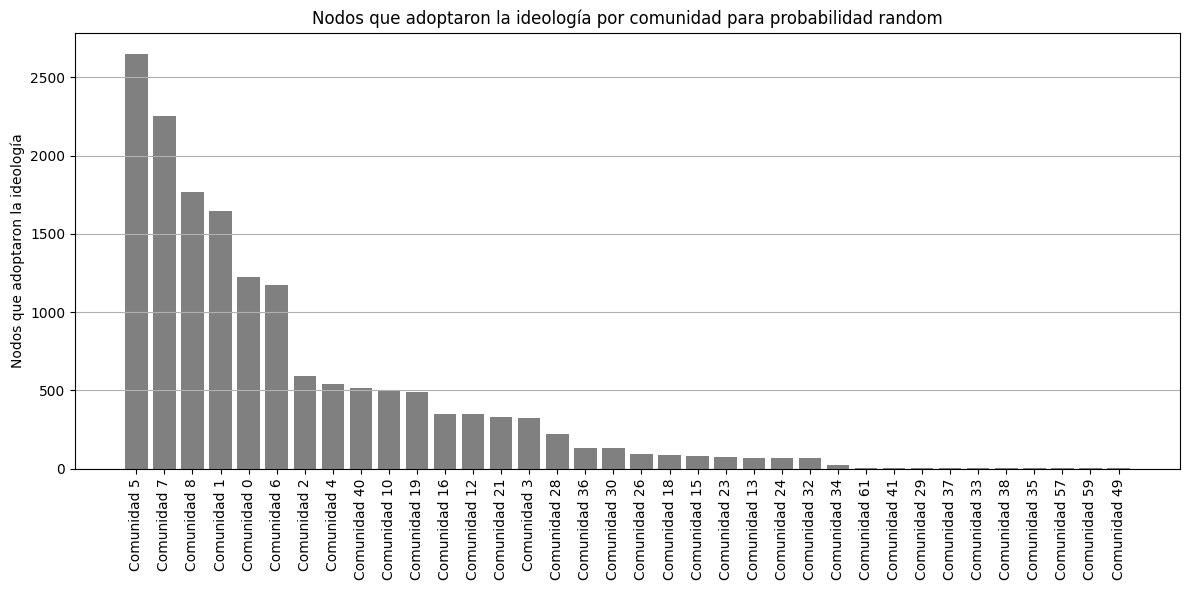

In [ ]:
sorted_communities = [
    (5, 2651), (7, 2251), (8, 1768), (1, 1647), (0, 1227), (6, 1173), (2, 590),
    (4, 539), (40, 514), (10, 495), (19, 487), (16, 352), (12, 349), (21, 333),
    (3, 323), (28, 220), (36, 132), (30, 130), (26, 96), (18, 87), (15, 83),
    (23, 73), (13, 70), (24, 69), (32, 66), (34, 26), (61, 3), (41, 2),
    (29, 2), (37, 1), (33, 1), (38, 1), (35, 1), (57, 1), (59, 1), (49, 1)
]

# Extraer los nombres de las comunidades y los nodos activados
communities = [f"Comunidad {community}" for community, _ in sorted_communities]
activations = [count for _, count in sorted_communities]

# Crear la gráfica de "nodos que adoptaron la ideología" vs "comunidad"
plt.figure(figsize=(12, 6))
plt.bar(communities, activations, color='gray')

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología por comunidad para probabilidad random")
plt.ylabel("Nodos que adoptaron la ideología")
plt.xticks(rotation=90)  # Rotar los nombres de las comunidades para mejor legibilidad
plt.grid(axis='y')

# Ajustar el diseño para evitar que los nombres de las comunidades se superpongan
plt.tight_layout()

# Mostrar la gráfica
plt.show()


¿Siguen una ley de potencias?

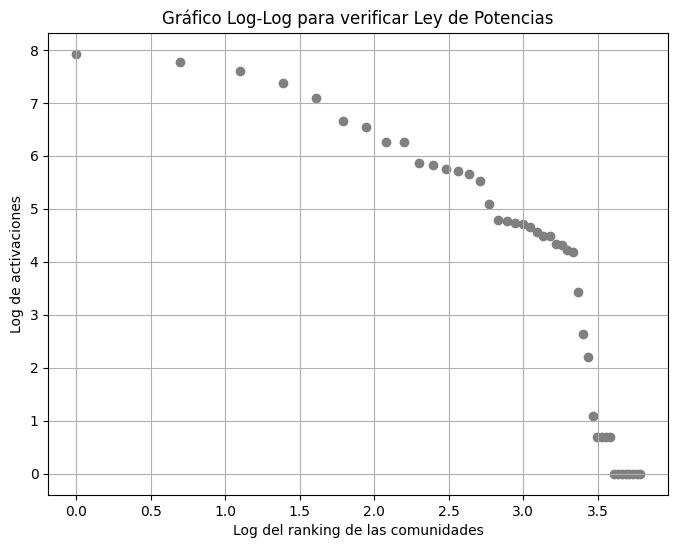

Pendiente (slope): -2.5632533628396272
Intercepción (intercept): 11.149998932870487
Coeficiente de determinación R^2: 0.7422753707871088


In [ ]:
# Los datos de activaciones de las comunidades
activations = [2775, 2392, 2016, 1583, 1211, 777, 700, 522, 522, 356, 340, 312, 302, 289, 252, 163,
               120, 119, 114, 112, 106, 95, 89, 89, 77, 75, 68, 66, 31, 14, 9, 3, 2, 2, 2, 2,
               1, 1, 1, 1, 1, 1, 1, 1]

# Convertir los datos a escala logarítmica
log_activations = np.log(activations)
log_rank = np.log(np.arange(1, len(activations) + 1))

# Crear gráfico log-log
plt.figure(figsize=(8, 6))
plt.scatter(log_rank, log_activations, color='gray', marker='o')
plt.title('Gráfico Log-Log para verificar Ley de Potencias')
plt.xlabel('Log del ranking de las comunidades')
plt.ylabel('Log de activaciones')
plt.grid(True)
plt.show()

# Ajustar una línea recta a los datos en el gráfico log-log
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(log_rank, log_activations)

print(f"Pendiente (slope): {slope}")
print(f"Intercepción (intercept): {intercept}")
print(f"Coeficiente de determinación R^2: {r_value**2}")


###Para la probabilidad condicionada:

In [ ]:
from collections import defaultdict

# Función para correr el modelo de cascada independiente con probabilidad condicionada por el valor de POST_LABEL
def independent_cascade_post_label_prob(G, initial_nodes, steps=10):
    activated = set(initial_nodes)  # Nodos que empiezan activados
    newly_activated = set(initial_nodes)  # Nodos activados en la iteración actual

    for step in range(steps):
        next_activated = set()  # Nodos que se activarán en la siguiente ronda

        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    # Obtener el valor de post_label en el enlace que conecta 'node' con 'neighbor'
                    post_label = G.edges[node, neighbor]['post_label']

                    # Establecer la probabilidad de propagación basada en el valor de post_label
                    if post_label == 1:
                        prob_spread = random.uniform(0.0, 0.49)
                    elif post_label == 0:
                        prob_spread = 0.5
                    elif post_label == -1:
                        prob_spread = random.uniform(0.51, 1.0)

                    # Propagar la ideología con la probabilidad definida
                    if random.random() < prob_spread:
                        next_activated.add(neighbor)

        newly_activated = next_activated
        activated.update(newly_activated)

        # Si no hay más nodos para activar, terminamos
        if not newly_activated:
            break

    return activated  # Retorna el conjunto de nodos activados al final del proceso

# Nodos iniciales (los 45 nodos más centrales con post_label = -1)
initial_nodes = top_45_node_names

# Ejecutar el modelo de cascada independiente en el grafo G1 con probabilidad condicionada
result_cond = independent_cascade_post_label_prob(G1, initial_nodes, steps=10)

# Mostrar el número de nodos activados por la ideología
print(f"Número de nodos que adoptaron la ideología: {len(result_cond)}")

# Detección de comunidades usando Louvain en el grafo no dirigido
partition = community_louvain.best_partition(G1.to_undirected())

# Agrupar los nodos activados por comunidad
communities_activated = defaultdict(int)  # Diccionario {comunidad: número de nodos activados}
for node in result_cond:
    if node in partition:  # Verificar si el nodo está en la partición
        community = partition[node]
        communities_activated[community] += 1

# Ordenar las comunidades por el número de nodos activados, de mayor a menor
sorted_communities = sorted(communities_activated.items(), key=lambda x: x[1], reverse=True)

# Mostrar las comunidades y el número de nodos activados en cada una
print("Comunidades a las que pertenecen los nodos que adoptaron la ideología:")
for community, count in sorted_communities:
    print(f"Comunidad {community} tiene {count} nodos activados")


Número de nodos que adoptaron la ideología: 10375
Comunidades a las que pertenecen los nodos que adoptaron la ideología:
Comunidad 6 tiene 2138 nodos activados
Comunidad 9 tiene 1491 nodos activados
Comunidad 39 tiene 1304 nodos activados
Comunidad 2 tiene 913 nodos activados
Comunidad 8 tiene 816 nodos activados
Comunidad 10 tiene 607 nodos activados
Comunidad 31 tiene 471 nodos activados
Comunidad 14 tiene 427 nodos activados
Comunidad 13 tiene 385 nodos activados
Comunidad 16 tiene 258 nodos activados
Comunidad 44 tiene 208 nodos activados
Comunidad 19 tiene 182 nodos activados
Comunidad 22 tiene 154 nodos activados
Comunidad 5 tiene 136 nodos activados
Comunidad 3 tiene 132 nodos activados
Comunidad 12 tiene 132 nodos activados
Comunidad 15 tiene 121 nodos activados
Comunidad 26 tiene 117 nodos activados
Comunidad 37 tiene 64 nodos activados
Comunidad 27 tiene 63 nodos activados
Comunidad 17 tiene 58 nodos activados
Comunidad 35 tiene 47 nodos activados
Comunidad 20 tiene 44 nodos 

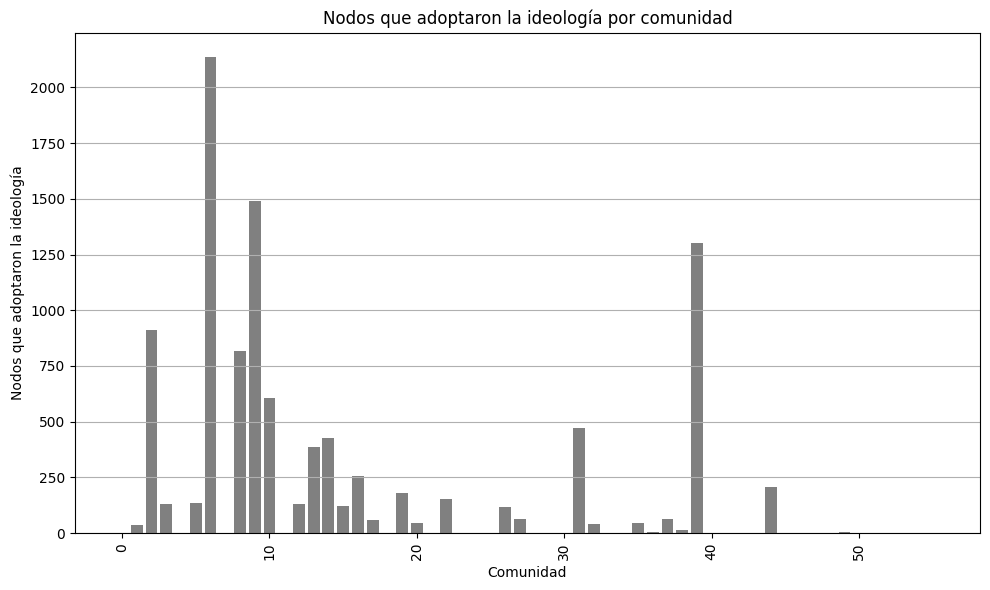

In [ ]:
import matplotlib.pyplot as plt

# Lista de comunidades y el número de nodos activados en cada una (salida del código anterior)
communities = [community for community, _ in sorted_communities]
activations = [count for _, count in sorted_communities]

# Crear la gráfica de "nodos que adoptaron la ideología" vs "comunidad"
plt.figure(figsize=(10, 6))
plt.bar(communities, activations, color='gray')

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología por comunidad")
plt.xlabel("Comunidad")
plt.ylabel("Nodos que adoptaron la ideología")
plt.xticks(rotation=90)  # Rotar los nombres de las comunidades para mejor legibilidad
plt.grid(axis='y')

# Mostrar la gráfica
plt.tight_layout()
plt.show()


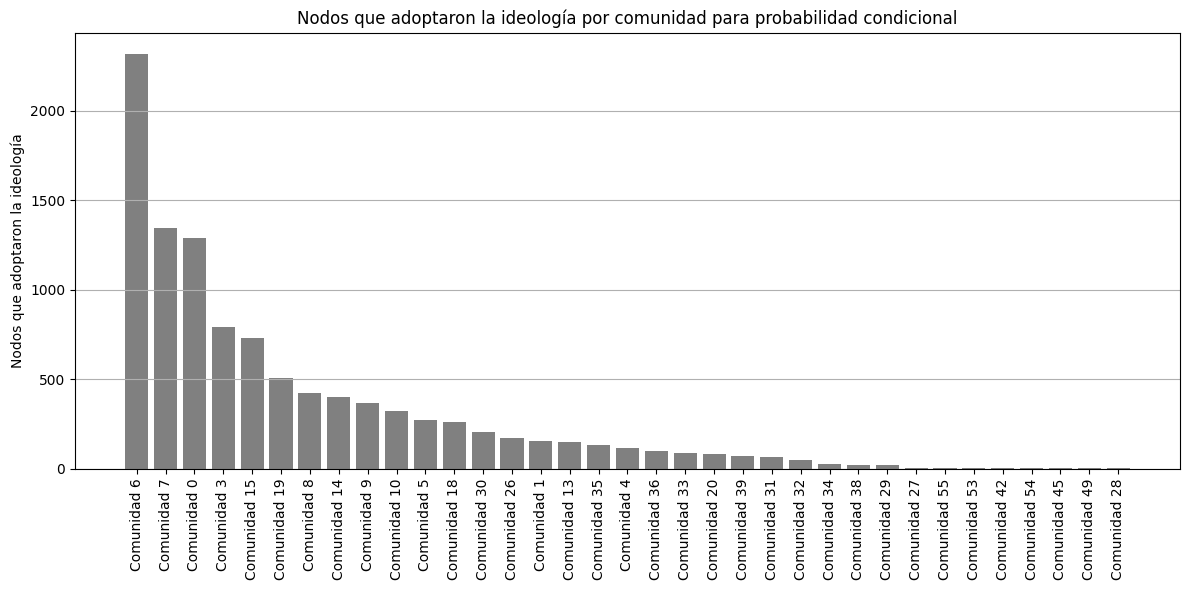

In [ ]:
import matplotlib.pyplot as plt

# Usar la lista de comunidades activadas ordenadas, del ejemplo dado
sorted_communities = [
    (6, 2318), (7, 1346), (0, 1286), (3, 790), (15, 729), (19, 507), (8, 423), (14, 400),
    (9, 365), (10, 321), (5, 269), (18, 258), (30, 204), (26, 172), (1, 156), (13, 148),
    (35, 133), (4, 115), (36, 96), (33, 86), (20, 80), (39, 68), (31, 63), (32, 46),
    (34, 27), (38, 19), (29, 18), (27, 2), (55, 2), (53, 2), (42, 1), (54, 1), (45, 1),
    (49, 1), (28, 1)
]

# Extraer los nombres de las comunidades y los nodos activados
communities = [f"Comunidad {community}" for community, _ in sorted_communities]
activations = [count for _, count in sorted_communities]

# Crear la gráfica de "nodos que adoptaron la ideología" vs "comunidad"
plt.figure(figsize=(12, 6))
plt.bar(communities, activations, color='gray')

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología por comunidad para probabilidad condicional")
plt.ylabel("Nodos que adoptaron la ideología")
plt.xticks(rotation=90)  # Rotar los nombres de las comunidades para mejor legibilidad
plt.grid(axis='y')

# Ajustar el diseño para evitar que los nombres de las comunidades se superpongan
plt.tight_layout()

# Mostrar la gráfica
plt.show()


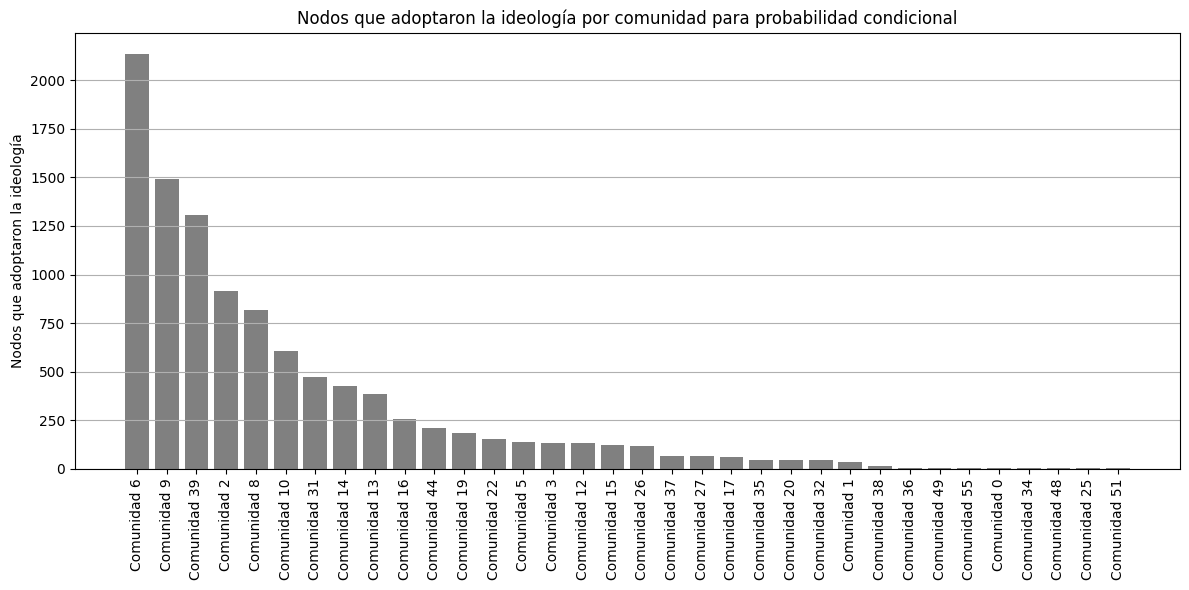

In [ ]:
import matplotlib.pyplot as plt

# Usar la nueva lista de comunidades activadas
sorted_communities = [
    (6, 2138), (9, 1491), (39, 1304), (2, 913), (8, 816), (10, 607), (31, 471),
    (14, 427), (13, 385), (16, 258), (44, 208), (19, 182), (22, 154), (5, 136),
    (3, 132), (12, 132), (15, 121), (26, 117), (37, 64), (27, 63), (17, 58),
    (35, 47), (20, 44), (32, 42), (1, 36), (38, 15), (36, 5), (49, 3),
    (55, 1), (0, 1), (34, 1), (48, 1), (25, 1), (51, 1)
]

# Extraer los nombres de las comunidades y los nodos activados
communities = [f"Comunidad {community}" for community, _ in sorted_communities]
activations = [count for _, count in sorted_communities]

# Crear la gráfica de "nodos que adoptaron la ideología" vs "comunidad"
plt.figure(figsize=(12, 6))
plt.bar(communities, activations, color='gray')

# Etiquetas y título del gráfico
plt.title("Nodos que adoptaron la ideología por comunidad para probabilidad condicional")
plt.ylabel("Nodos que adoptaron la ideología")
plt.xticks(rotation=90)  # Rotar los nombres de las comunidades para mejor legibilidad
plt.grid(axis='y')

# Ajustar el diseño para evitar que los nombres de las comunidades se superpongan
plt.tight_layout()

# Mostrar la gráfica
plt.show()
